# Customized Named Entity Recognition

- Using Kaggle Competition 
- https://www.kaggle.com/davidg089/all-djtrum-tweets

# 1)- Importing key modules

In [1]:
from __future__ import unicode_literals

#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import re
import string
import pdftotext # For pdfto text conversion
import docx2txt # for converting docx to .txt format
from collections import Counter
import sys
import pandas as pd
from collections import defaultdict
import codecs # for encoding scheme of text files
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy

In [3]:
nlp = spacy.load('en_core_web_md')

In [4]:
%reload_ext version_information
%version_information pandas,spacy, seaborn, matplotlib

Software versions
Python 3.7.5 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.10.2
OS Darwin 19.3.0 x86_64 i386 64bit
pandas 0.25.3
spacy 2.2.3
seaborn 0.9.0
matplotlib 3.1.1
Sat Mar 21 21:10:48 2020 CET

# 2)- Loading Data

In [5]:
tweets = pd.read_csv("all_djt_tweets.csv")

In [6]:
tweets.head()

,Unnamed: 0,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,0,Twitter for iPhone,Over 90% approval rating for your all time fav...,Mon Aug 27 00:39:38 +0000 2018,27040,106838.0,False,1.033877e+18
1,1,Twitter for iPhone,“Mainstream Media tries to rewrite history to ...,Sun Aug 26 22:01:33 +0000 2018,21346,76682.0,False,1.033837e+18
2,2,Twitter for iPhone,Fantastic numbers on consumer spending release...,Sun Aug 26 14:31:06 +0000 2018,18960,87334.0,False,1.033724e+18
3,3,Twitter for iPhone,"...And it will get, as I have always said, muc...",Sun Aug 26 14:27:16 +0000 2018,14963,62956.0,False,1.033723e+18
4,4,Twitter for iPhone,RT @realDonaldTrump: Social Media Giants are s...,Sun Aug 26 14:25:47 +0000 2018,50142,0.0,True,1.033722e+18


Our feature of interest is "text"

In [7]:
tweets.shape

(328053, 8)

In [8]:
tweets.text[0]

'Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!'

In [9]:
tweets.dtypes

Unnamed: 0         object
source             object
text               object
created_at         object
retweet_count      object
favorite_count    float64
is_retweet         object
id_str            float64
dtype: object

In [10]:
tweets.isnull().sum()

Unnamed: 0        163840
source            277677
text              277677
created_at        293213
retweet_count     293213
favorite_count    293213
is_retweet        293216
id_str            293216
dtype: int64

Couple of missing values. Let's concentrate on text for our analysis

# 3)- Feature of Analysis

In [11]:
tweet_text=tweets['text']

In [12]:
tweet_text[0]

'Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!'

In [13]:
type(tweet_text)

pandas.core.series.Series

In [14]:
len(tweet_text)

328053

In [15]:
doc = nlp(tweet_text[0])

In [16]:
type(doc)

spacy.tokens.doc.Doc

In [17]:
doc

Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!

In [18]:
len(doc)

57

Observe difference in length of  spacy token vs doc as of series

In [19]:
for ent in doc.ents:
        print(f'Entity: {ent}, Label: {ent.label_}, {spacy.explain(ent.label_)}')

Entity: 90%, Label: PERCENT, Percentage, including "%"
Entity: the Republican Party, Label: ORG, Companies, agencies, institutions, etc.
Entity: 52%, Label: PERCENT, Percentage, including "%"
Entity: the Fake News Media, Label: ORG, Companies, agencies, institutions, etc.


### Visualize results

In [20]:
displacy.render(doc,style='ent',jupyter=True)

In [21]:
doc2 = nlp(tweet_text[15])

In [22]:
displacy.render(doc2,style='ent',jupyter=True)

# 4)- Redacting Entities

Suppose we want to keep names in above cases as hidden i.e to automatically redact names.

We shall follow these steps

- 1. find all PERSON names
- 2. replace these by a filler like ["REDACTED"]

In [23]:
def redact_names(text):
    doc = nlp(text)
    redacted_sentence = []
    for ent in doc.ents:
        ent.merge()
    for token in doc:
        if token.ent_type_ == "PERSON":
            redacted_sentence.append("[REDACTED]")
        else:
            redacted_sentence.append(token.string)
    return "".join(redacted_sentence)

thanks to https://www.kaggle.com/nirant/hitchhiker-s-guide-to-nlp-in-spacy/data

In [24]:
one_tweet = redact_names(tweets['text'][15])
doc = nlp(one_tweet)

In [25]:
spacy.displacy.render(doc, style='ent',jupyter=True)

So, we have hidden person name. This can be done with other entities as well.

# 5)- Showing Specific Entities

In [26]:
doc3=nlp(tweet_text[20])

In [27]:
spacy.displacy.render(doc3, style='ent',jupyter=True)

Suppose in above case, we only want to see only "GPE" Entity .

### 5a) Using Option in displacy

In [28]:
options={'ents':['GPE']}

In [29]:
displacy.render(doc3,style='ent',jupyter=True, options=options)

What if we want to view multiple entities with our choice i.e GPE and PERSON

In [30]:
options={'ents':['GPE','PERSON']}

In [31]:
displacy.render(doc3,style='ent',jupyter=True, options=options)

### 5b)- Using filering

In [32]:
for ent in doc3.ents:
    if ent.label_ in ["GPE","PERSON"]:
        text,entity=(ent.text, ent.label_)
        print(text, entity)

Scott Morrison PERSON
the United States GPE
Australia GPE


In [33]:
text_format=[]
entity=[]

for ent in doc3.ents:
    if ent.label_ in ["GPE","PERSON"]:
        text_format.append(ent.text)
        entity.append(ent.label_)

In [34]:
df_entity = pd.DataFrame({'TEXT': [], 'ENT': []})
df_entity

,TEXT,ENT


In [35]:
df_entity['TEXT']=text_format
df_entity["ENT"]=entity
df_entity

,TEXT,ENT
0,Scott Morrison,PERSON
1,the United States,GPE
2,Australia,GPE


# 6)- What are most common issues in tweets

In [36]:
text = tweets['text'].str.cat(sep=' ')
# spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
# Since `text` might be longer than that, we will slice it off here
max_length = 1000000-1
text = text[:max_length]

In [37]:
text[:500]

'Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please! “Mainstream Media tries to rewrite history to credit Obama for Trump accomplishments. Since President Trump took office, the economy is booming. The stronger the economy gets, the more desperate his critics are. O had weakest'

In [38]:
len(text)

999999

# 6a.Cleaning data

In [39]:
# removing URLs and '&amp' substrings using regex
import re
url_reg  = r'[a-z]*[:.]+\S+'
text   = re.sub(url_reg, '', text)
noise_reg = r'\&amp'
text   = re.sub(noise_reg, '', text)

In [40]:
len(text)

915337

### 6b.Convert to Spacy token

In [41]:
doc = nlp(text)

In [42]:
len(doc)

186429

In [43]:
items_of_interest = list(doc.noun_chunks)

In [44]:
# each element in this list is spaCy's inbuilt `Span`, which is not useful for us
items_of_interest = [str(x) for x in items_of_interest]
# so we've converted it to string

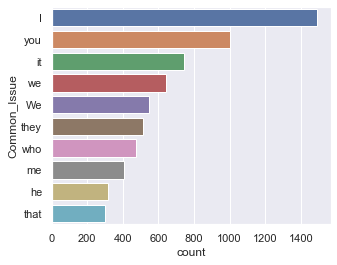

In [45]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
df_nouns = pd.DataFrame(items_of_interest, columns=["Common_Issue"])
plt.figure(figsize=(5,4))
sns.countplot(y="Common_Issue",
             data=df_nouns,
             order=df_nouns["Common_Issue"].value_counts().iloc[:10].index)
plt.show()

### 6c.remove these filler words

In [46]:
common_issues = []
for token in doc:
    if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
        common_issues.append(token)
        
common_issues = [str(x) for x in common_issues]

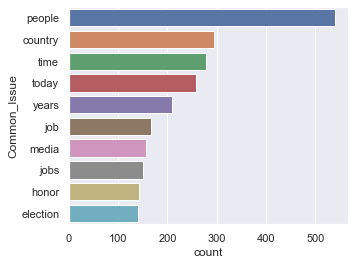

In [47]:
df_nouns = pd.DataFrame(common_issues, columns=["Common_Issue"])
plt.figure(figsize=(5,4))
sns.countplot(y="Common_Issue",
             data=df_nouns,
             order=df_nouns["Common_Issue"].value_counts().iloc[:10].index)
plt.show()

### 6d. Exploring Entities

In [48]:
entities = []
for ent in doc.ents:
    if ent.label_ not in ["PERCENT", "CARDINAL", "DATE"]:
#         print(ent.text,ent.label_)
        entities.append(ent.text.strip())

In [49]:
from collections import Counter
ent_counter = Counter(entities)
ent_counter.most_common()[:10]

[('Democrats', 279),
 ('American', 209),
 ('Trump', 200),
 ('RT', 189),
 ('Hillary', 188),
 ('FBI', 178),
 ('America', 177),
 ('Russia', 177),
 ('Hillary Clinton', 169),
 ('MAGA', 164)]

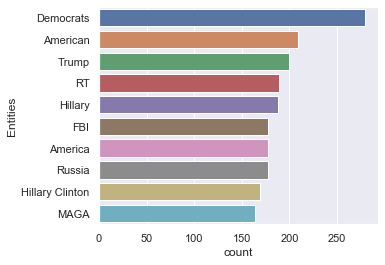

In [50]:
df_ent = pd.DataFrame(entities, columns=["Entities"])
plt.figure(figsize=(5,4))
sns.countplot(y="Entities",
             data=df_ent,
             order=df_ent["Entities"].value_counts().iloc[0:10].index)
plt.show()

### 6e. Word Cloud

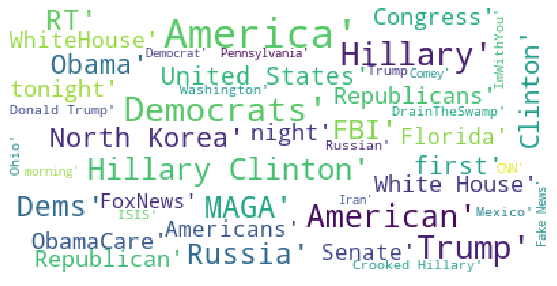

In [51]:
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str(entities))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 6f. Creating table with Entity Class and Entity Type

In [52]:
df_table = pd.DataFrame({'entity': [], 'label': []})
df_table

,entity,label


In [53]:
df_table['entity']=[x.text for x in doc.ents]
df_table['label']=[x.label_ for x in doc.ents]
df_table['start']=[x.start_char for x in doc.ents]
df_table['end']=[x.end_char for x in doc.ents]

In [54]:
df_table.shape

(17654, 4)

In [55]:
df_table.head()

,entity,label,start,end
0,90%,PERCENT,5,8
1,the Republican Party,ORG,78,98
2,52%,PERCENT,103,106
3,the Fake News Media,ORG,159,178
4,Mainstream Media tries to rewrite history,WORK_OF_ART,276,317


**Filter only for ORG, PERSON, COUNTRY and LAW**

In [56]:
df_entity_filter=df_table[(df_table.label=="PERSON") | (df_table.label=="ORG") |(df_table.label=="COUNTRY")
             | (df_table.label=="LAW")]

In [57]:
df_entity_filter.shape

(8103, 4)

In [58]:
df_entity_filter.head(10)

,entity,label,start,end
1,the Republican Party,ORG,78,98
3,the Fake News Media,ORG,159,178
5,Obama,PERSON,328,333
6,Trump,PERSON,338,343
7,Trump,PERSON,377,382
9,Social Media Giants,ORG,714,733
11,FBI,ORG,878,881
13,Hillary Emails,PERSON,919,933
14,RT,ORG,975,977
15,Christopher Steele,PERSON,1004,1022


In [59]:
df_entity_filter.tail(10)

,entity,label,start,end
17618,Hillary Clinton's,PERSON,913208,913225
17625,Bernie Sanders,PERSON,913693,913707
17626,Hillary Clinton,PERSON,913744,913759
17627,Hillary Clinton,PERSON,913842,913857
17631,NeverDems,ORG,914105,914114
17634,@nytimes,ORG,914299,914307
17636,Hillary Clinton,PERSON,914433,914448
17644,Hillary,PERSON,914992,914999
17646,Katie Couric,PERSON,915068,915080
17650,@FoxNews,ORG,915265,915273


# 7)- NLP Analysis of Tweets

We want to find out what Trump is saying in these Tweets about

- Himself e.g. "I am rich".
- Russia
- Democrats